<a href="https://colab.research.google.com/github/henrykohl/DeepLearningByPytorchTutorial/blob/master/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">08. PyTorch Experiment Tracking Exercises</font>

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

In [2]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3710, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 3710 (delta 176), reused 304 (delta 155), pack-reused 3378
Receiving objects: 100% (3710/3710), 648.79 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (2132/2132), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
  train_dir=train_dir,
  test_dir=test_dir,
  transform=manual_transforms, # use manually created transforms
  batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2fc721f1f0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

In [10]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

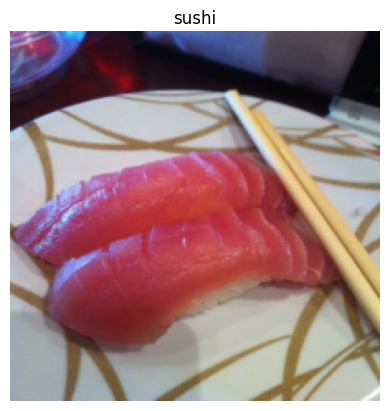

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

<font color="purple">Need:

1. PatchEmbedding (turn images into embedded patches)
2. Transformer Encoder layer (this is comprised of alternating MSA and MLP blocks)
3. Stack multiple transformer encoder layers on top of each other
4. MLP head
5. Put it all together to create ViT

### <font color="purple">1. Make PatchEmbedding layer

<font color="purple">Code from: https://www.learnpytorch.io/08_pytorch_paper_replicating/#45-turning-the-vit-patch-embedding-layer-into-a-pytorch-module

In [12]:
# TODO: your code

In [13]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

In [18]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.
  
  Args:
    in_channels (int): Number of color channels for the input images. Defaults to 3.
    patch_size (int): Size of patches to convert input image into. Defaults to 16.
    embedding_dim (int): Size of embedding to turn image into. Defaults to 768. 
  """
  # 2. Initialize the class with appropriate variables
  def __init__(self,
          in_channels:int=3,
          patch_size:int=16,
          embedding_dim:int= 768):
    super().__init__()
    
    self.patch_size = patch_size

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                  out_channels=embedding_dim,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                     end_dim=3)
    
  # 5. Define the forward method
  def forward(self,x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass   
    x_patched=self.patcher(x)
    x_flattened=self.flatten(x_patched)

    # 6. Make sure the output shape has the right order 
    return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    

In [21]:
# patch_embedding = PatchEmbedding(patch_size=16) # 可以不需要patch_size=16
patch_embedding = PatchEmbedding()  
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)") 

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


### <font color="purple">2. TransformerEncoderLayer 

<font color="purple">Can build a Transformer Encoder Layer with: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [22]:
# Hyperparameters from Table 1 and Table 3 for ViT-Base
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, 
                              nhead=12, 
                              dim_feedforward=3072, 
                              dropout=0.1, 
                              activation="gelu", 
                              batch_first=False, 
                              norm_first=False)

transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [25]:
from torchinfo import summary 

summary(model=transformer_encoder_layer,
    input_size=patch_embedding_output.shape)

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            --
├─MultiheadAttention: 1-1                [32, 196, 768]            2,362,368
├─Dropout: 1-2                           [32, 196, 768]            --
├─LayerNorm: 1-3                         [32, 196, 768]            1,536
├─Linear: 1-4                            [32, 196, 3072]           2,362,368
├─Dropout: 1-5                           [32, 196, 3072]           --
├─Linear: 1-6                            [32, 196, 768]            2,360,064
├─Dropout: 1-7                           [32, 196, 768]            --
├─LayerNorm: 1-8                         [32, 196, 768]            1,536
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 151.22
Input size (MB): 19.27
Forward/backward pass size (MB): 269.75
Params size (MB): 18.90
Estimated Total Size (MB): 307.92

### <font color="purple">3. Stack Transformer Encoder Layers on top of each other to make the full Transformer Encoder

<font color="purple">According to Table 1 of the ViT paper, the ViT-Base model uses a stack of 12 Transformer Encoder layers.

We can stack Transformer Encoder Layers on top of each other using: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder</font> 

In [26]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer,
                         num_layers=12)
# transformer_encoder

In [ ]:
# summary(model=transformer_encoder,
#         input_size=patch_embedding_output.shape)

### <font color="purple">5. Put it all together and create ViT 

We're skipping step 4, so that can be incorported the into the overall ViT architecture.</font>

In [30]:
class ViT(nn.Module):
  def __init__(self,
         img_size=224, # from Table 3
         num_channels=3,
         patch_size=16,
         embedding_dim=768, # from Table 1
         dropout=0.1, 
         mlp_size=3072, # from Table 1
         num_transformer_layers=12, # from Table 1
         num_heads=12, # from Table 1 (number of multi-head self attention heads)
         num_classes=1000): # generic number of classes (this can be adjusted
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                         patch_size=patch_size,
                         embedding_dim=embedding_dim)
    
    # 2. Create class token
    self.class_token = nn.Parameters(torch.rand(1, 1, embedding_dim),
                      requires_grad=True)
    
    # 3. Create positional embedding
    num_patches = (img_size*img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameters(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout 
    self.embedding_dropout = nn.Dropout(p=0.1)

    # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                   nhead=num_heads,
    #                                   dim_feedforward=mlp_size,
    #                                   activation="gelu",
    #                                   batch_first=True,
    #                                   norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                      nhead=num_heads,
                                                      dim_feedforward=mlp_size,
                                                      activation="gelu",
                                                      batch_first=True,
                                                      norm_first=True),# Create a single Transformer Encoder Layer
                                num_layers=num_transformer_layers)
    
    # 7. Create MLP head(classifier會不會更好)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
             out_features=num_classes)
    )

  def forward(self,x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape) # 測試用

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size,-1,-1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token,x),dim=1)
    # print(x.shape) # 測試用

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape) # 測試用

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head(classifier會不會更好)
    x = self.mlp_head(x[:,0])

    return x

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [ ]:
# TODO: your code

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [ ]:
# TODO: your code

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# TODO: your code

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-22k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [ ]:
# TODO: your explanations of the above terms